In [15]:
import datetime
import os

import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from torchmetrics.functional.image import peak_signal_noise_ratio

from tqdm import tqdm

import generators
from utils.dataLoaders import get_rotated_mnist_dataloader
from utils.checkpoints import load_gen_disc_from_checkpoint, load_checkpoint, print_checkpoint

In [16]:
def plot_comparison(tar: torch.Tensor, approx: torch.Tensor, title: str):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tar.detach().cpu().numpy(), cmap='gray')
    ax[0].set_title('Target')
    ax[1].imshow(approx.detach().cpu().numpy(), cmap='gray')
    ax[1].set_title('Approximation')
    plt.suptitle(title)
    plt.show()

In [17]:
device = 'cpu'

IMG_SIZE = 28


checkpoint_path = 'trained_models/p4_rot_mnist/2023-11-09_18:14:22/checkpoint_20000'
gen, _ = load_gen_disc_from_checkpoint(checkpoint_path, device=device, print_to_console=True)
checkpoint = load_checkpoint(checkpoint_path)
print_checkpoint(checkpoint)
LATENT_DIM = checkpoint['latent_dim']
gen.eval()

max_x_y = 3
grid_size = 3000
inc = 2 * max_x_y / np.sqrt(grid_size)

x = np.arange(-max_x_y, max_x_y, inc)
y = np.arange(-max_x_y, max_x_y, inc)
grid_size = len(x) * len(y)
grid = np.meshgrid(x, y)
inputs = torch.from_numpy(np.array(grid).T.reshape(-1, 2)).type(torch.float32)

project_root = os.getcwd()
test_dataset, loader = get_rotated_mnist_dataloader(root=project_root,
                                                    batch_size=1,
                                                    shuffle=False,
                                                    one_hot_encode=True,
                                                    num_examples=10000,
                                                    num_rotations=0,
                                                    train=False,
                                                    single_class=8)

loader_iterator = iter(loader)
target_images, input_labels = next(loader_iterator)
#target_images, input_labels = next(loader_iterator)
#target_images, input_labels = next(loader_iterator)
#target_images, input_labels = next(loader_iterator)
target_images = target_images.to(device)
input_labels = input_labels.repeat(grid_size, 1).type(torch.float32).to(device)

out = gen(inputs, input_labels)
loss = torch.mean(torch.nn.functional.mse_loss(out, target_images.repeat(grid_size, 1, 1, 1), reduction='none'), dim=(1,2,3))
loss = loss.detach().cpu().numpy().reshape(len(x), len(y))

--------------------------------
Loaded checkpoint from: trained_models/p4_rot_mnist/2023-11-09_18:14:22/checkpoint_20000
Generator architecture: p4_rot_mnist
Discriminator architecture: p4_rot_mnist
--------------------------------


iterations: ................ 20000
gen_arch: .................. p4_rot_mnist
disc_arch: ................. p4_rot_mnist
batch_size: ................ 64
n_classes: ................. 10
latent_dim: ................ 2
use_ggan_training_loop: .... True
loss_type: ................. rel_avg
gp_type: ................... zero_centered
gp_strength: ............... 0.1
disc_update_steps: ......... 2
beta_1: .................... 0.0
beta_2: .................... 0.9
lr_g: ...................... 0.0001
lr_d: ...................... 0.0004
img_shape: ................. (1, 28, 28)


Loading data and labels from directories 
      data: /Users/kianhunziker/Documents/UNI/UNIBAS/SemesterProject/G_GAN/datasets/RotMNIST/data_10000ex_0rot_180deg_test.npy 
      labels: /Users/k

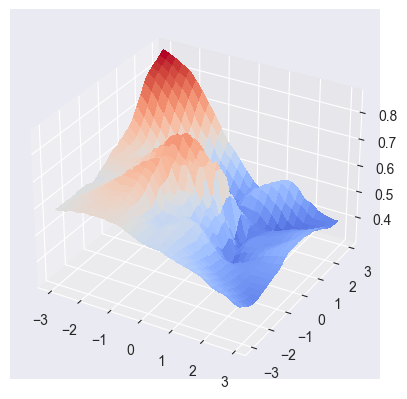

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(grid[1], grid[0], loss, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [19]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(x=grid[1], y=grid[0], z=loss)])

fig.update_layout(title='Loss Landscape', autosize=False,
                  width=800, height=600,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

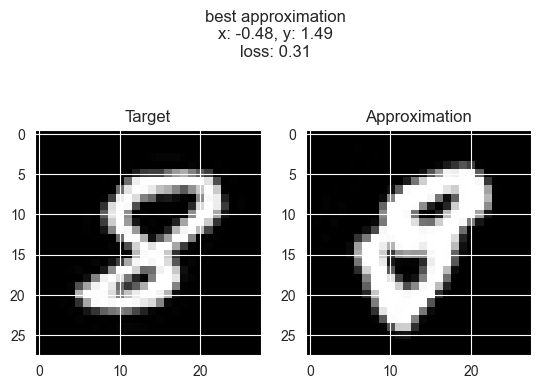

In [20]:
min_index = np.unravel_index(np.argmin(loss, axis=None), loss.shape)
min_x = grid[1][min_index[0], 0]
min_y = grid[0][0, min_index[1]]
#print(min_x, min_y)
min_coords = torch.tensor([min_x, min_y]).type(torch.float32).unsqueeze(0)
best_approx = gen(min_coords, input_labels[0].unsqueeze(0))
min_loss = torch.nn.functional.mse_loss(best_approx, target_images[0].unsqueeze(0))
plot_comparison(target_images[0, 0], best_approx[0, 0], f'best approximation\nx: {min_x:.2f}, y: {min_y:.2f}\nloss: {min_loss:.2f}')

tensor(0.6987, grad_fn=<MseLossBackward0>)


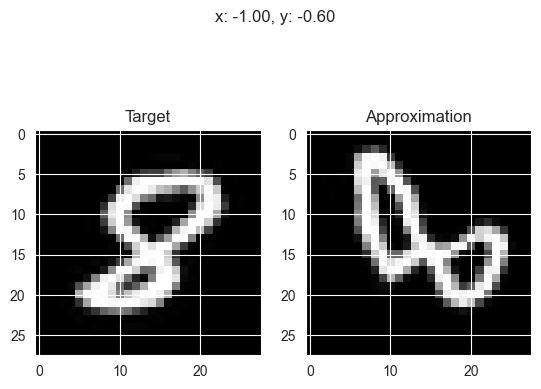

In [21]:
sanity_check_input = torch.tensor([-1,-0.6]).type(torch.float32).unsqueeze(0)
o = gen(sanity_check_input, input_labels[0].unsqueeze(0))
l = torch.nn.functional.mse_loss(o, target_images[0].unsqueeze(0))
print(l)
plot_comparison(target_images[0, 0], o[0, 0], f'x: {sanity_check_input[0, 0]:.2f}, y: {sanity_check_input[0, 1]:.2f}')